In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import imageio as iio
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
nn.ConvTranspose2d?

In [3]:
# Define the parameters for the training process
n_epochs = 100
batch_size = 64
lr = 0.002
b1 = 0.5
b2 = 0.999
latent_dim = 100
mean = 0.5
std = 0.5

# Data preprocessing

In [4]:
class MyDataset(Dataset):
  def __init__(self, im_fol, trans = None):
    super().__init__()
    self.im_fol = im_fol
    self.im_list = os.listdir(im_fol)
    self.trans = trans

  def __len__(self):
    return len(self.im_list)

  def __getitem__(self,idx):
    im = iio.imread(f"{self.im_fol}{self.im_list[idx]}")
    if self.trans:
      im = self.trans(im)

    return im

In [5]:
trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize([mean], [std])
                           ])
dataset = MyDataset('/kaggle/input/cub-200-2011/cub_200_2011_64x64_for_fid_10k/cub_200_2011_64x64_10k/', trans = trans )

In [6]:
img_shape = dataset[0].shape
channels, img_sizex, img_sizey = img_shape
print(img_shape)
print(channels)

torch.Size([3, 64, 64])
3


/tmp/ipykernel_22/1229826153.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = iio.imread(f"{self.im_fol}{self.im_list[idx]}")


/tmp/ipykernel_22/1229826153.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = iio.imread(f"{self.im_fol}{self.im_list[idx]}")


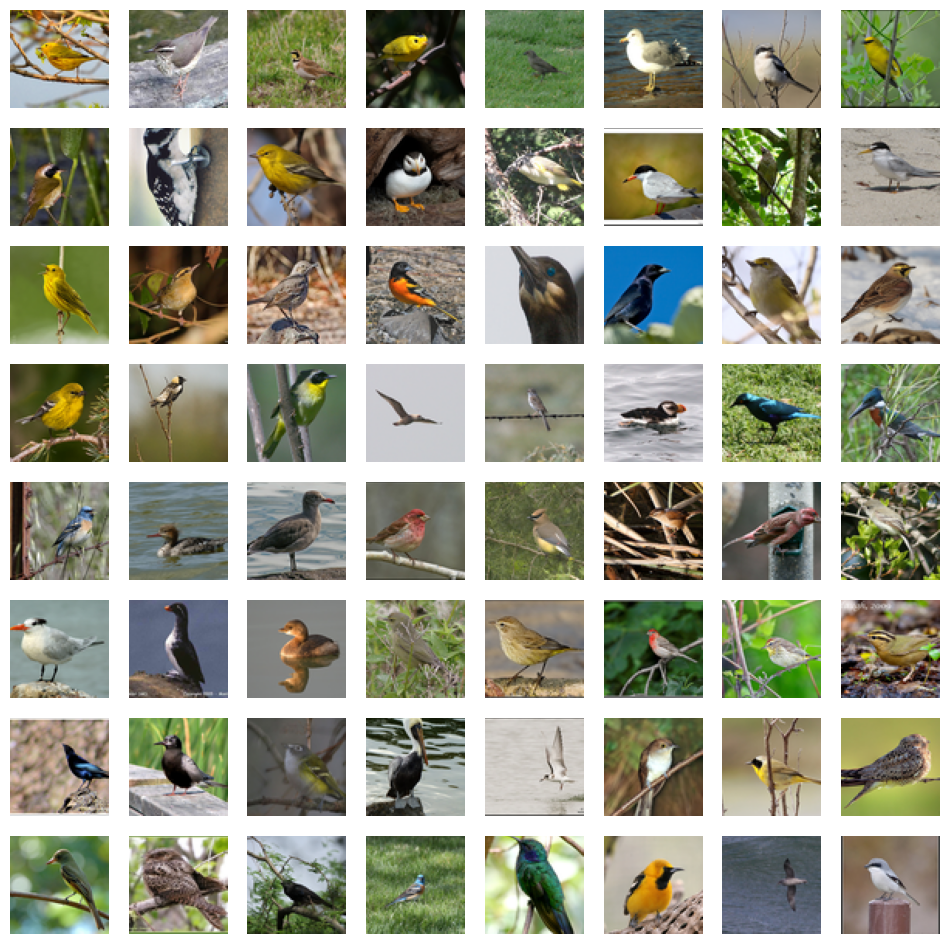

In [7]:
plt.figure(figsize=(12,12))
for i in range(64):
  plt.subplot(8,8, i+1)
  img = dataset[i] * std + mean # Denormalize the image: denormalized_image = (normalized_image * std) + mean
  plt.imshow(img.permute(1, 2, 0))
  plt.axis("off")

# DataLoader

In [8]:
dataloader = DataLoader(dataset, batch_size= batch_size, shuffle= False)

# GAN Model

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()

#         def block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, normalize=True):
#             layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
#             if normalize:
#                 layers.append(nn.BatchNorm2d(out_channels))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers

#         self.model = nn.Sequential(
#             # input is Z, going into a convolution
#             *block(latent_dim, 512, 4, 1, 0, normalize=False),  # First layer block
#             *block(512, 256, 4, 2, 1),  # 2nd layer block
#             *block(256, 128, 4, 2, 1),  # 3rd layer block
#             *block(128, 64, 4, 2, 1),  # 4th layer block
#             nn.ConvTranspose2d(64, channels, 4, 2, 1),  # Final Convolutional layer
#             nn.Tanh()  # Tanh activation for output
#         )

#     def forward(self, z):  # Forward propagation function
#         z = z.view(z.size(0), z.size(1), 1, 1)  # Reshape the input tensor in (B x C x H x W) format
#         img = self.model(z)  # Pass input through the model
#         return img  # Return the image

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, normalize=True):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
        # input is Z, going into a convolution
        *block(latent_dim, 512, 4, 1, 0, normalize=False),  # First layer block
        *block(512, 256, 4, 2, 1),  # 2nd layer block
        *block(256, 128, 4, 2, 1), # 3rd layer block
        *block(128, 64, 4, 2, 1),   # 4th layer block
        *block(64,32, 4, 2, 1),     # Added a fifth layer block
        nn.ConvTranspose2d(32, channels, 3, 1, 1), # Final Convolutional layer
        nn.Tanh() # Tanh activation for output       
        )

    def forward(self,z): # Forward propagation function
        z = z.view(z.size(0), z.size(1),1 ,1) # Reshape the input tensor in (B x C x H x W) format
        img = self.model(z) # Pass input through the model
        return img # Return the image


In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Function to create a convolutional layer block (Conv -> LeakyReLU)
        def block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
            return [
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.LeakyReLU(0.2, inplace=True)
            ]

        self.model = nn.Sequential(
            *block(channels, 32),  # First layer block
            *block(32, 64),  # Second layer block
            *block(64, 128),  # Second layer block
            *block(128, 256),  # Third layer block
            *block(256, 512),  # Fourth layer block
            nn.Conv2d(512, 1, 2, 1, 0),  # Final convolutional layer
            nn.Sigmoid()  # Sigmoid activation for output
        )

    def forward(self, img):  # Forward propagation function
        validity = self.model(img)  # Pass the image through the model
#         validity = validity.view(validity.size(0), 1)  # Forcing the shape of the output
        validity = validity.view(validity.size(0), -1)  # Flatten the output
        return validity  # Return the validity

In [13]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()

#         # Function to create a convolutional layer block (Conv -> LeakyReLU)
#         def block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
#             return [
#                 nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
#                 nn.LeakyReLU(0.2, inplace=True)
#             ]

#         self.model = nn.Sequential(
#             *block(channels, 64),  # First layer block
#             *block(64, 128),  # Second layer block
#             *block(128, 256),  # Third layer block
#             *block(256, 512),  # Fourth layer block
#             nn.Conv2d(512, 1, 4, 1, 0),  # Final convolutional layer
#             nn.Flatten(), # Flatten the output
#             nn.Linear(16, 1), # Fully connected layer to reshape the output
#             nn.Sigmoid()  # Sigmoid activation for output
#         )

#     def forward(self, img):  # Forward propagation function
#         validity = self.model(img)  # Pass the image through the model
#         return validity  # Return the validity

In [14]:
# We use binary cross-entropy loss for the adversarial loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize the generator and the discriminator
generator = Generator()
discriminator = Discriminator()

# If CUDA is available, we use it for the models and the loss function
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()


# We use the Adam optimizer for both the generator and the discriminator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))


# Initialize schedulers
scheduler_G = lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.1)
scheduler_D = lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.1)

#
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [15]:
!mkdir 'training_predictions01'

In [16]:
# Initialize list to store losses for Generator and Discriminator
g_losses = []
d_losses = []

# Training Loop
for epoch in tqdm(range(n_epochs)):  # Loop over the dataset multiple times, for each epoch
    g_loss_accum = 0.0
    d_loss_accum = 0.0
    num_batches = 0
    for i, (imgs) in enumerate(dataloader):  # Loop over each batch of real images in the dataset
#         print(imgs.shape)
        # Ground truths for real and fake images (real: 1, fake: 0)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input, this will be used for training the discriminator with real images
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()  # Clears the gradients of all optimized tensors
        # Sample noise as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))
#         print(z.shape)
        
        # zz = z.view(z.size(0), z.size(1), 1, 1) 
        # print(zz.shape)

        # Generate a batch of images from the noise
        gen_imgs = generator(z)
#         print(gen_imgs.shape)
#         print(valid.shape)
#         print(discriminator(gen_imgs).shape)


        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()  # Compute the gradient of g_loss w.r.t. the Generator's parameters
        optimizer_G.step()  # Update the Generator's weights
       

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()  # Clears the gradients of all optimized tensors

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)  # Loss for real images
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)  # Loss for fake images
        d_loss = (real_loss + fake_loss) / 2  # Take the average of these two losses

        d_loss.backward()  # Compute the gradient of d_loss w.r.t. the Discriminator's parameters
        optimizer_D.step()  # Update the Discriminator's weights
        

        # Accumulate losses for this batch
        g_loss_accum += g_loss.item()
        d_loss_accum += d_loss.item()
        num_batches += 1

    # Step the learning rate
    scheduler_G.step()
    scheduler_D.step()

    # Save average losses for this epoch
    g_losses.append(g_loss_accum / num_batches)
    d_losses.append(d_loss_accum / num_batches)
    
        # Save a batch of generated images every 10 epochs
    if epoch % 10 == 0 or epoch == 100:
        save_image(gen_imgs.data[:25], f"/kaggle/working/training_predictions01/epoch_{epoch}.png", nrow=5, normalize=True)        

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_22/1229826153.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = iio.imread(f"{self.im_fol}{self.im_list[idx]}")
100%|██████████| 100/100 [38:52<00:00, 23.33s/it]


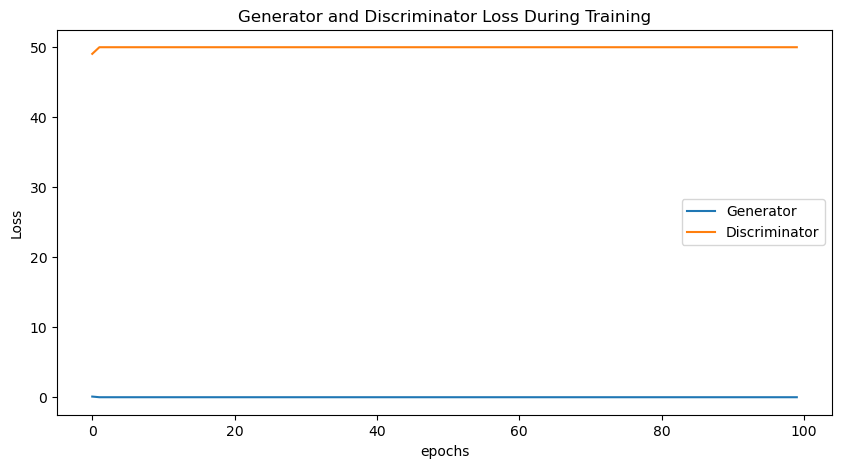

In [17]:
# Plotting the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="Generator")
plt.plot(d_losses,label="Discriminator")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()